## Imports

In [1]:
!pip install shap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import ast
import json

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

**About Dataset:**

id: Integer unique id of each movie

belongs_to_collection: Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format.

budget: Budget of a movie in dollars. Some row contains 0 values which mean unknown.

genres: Contains all the Genres Name & TMDB Id in JSON Format.

homepage: Contains the official URL of a movie.

imdb_id: IMDB id of a movie (string).

original_language: Two digit code of the original language, in which the movie was made.

original_title: The original title of a movie in original_language.

overview: Brief description of the movie.

popularity: Popularity of the movie.

poster_path: Poster path of a movie.

production_companies: All production company name and TMDB id in JSON format of a movie.

production_countries: Two digit code and full name of the production company in JSON format.

release_date: Release date of a movie in mm/dd/yy format.

runtime: Total runtime of a movie in minutes (Integer).

spoken_languages: Two digit code and full name of the spoken language.

status: Is the movie released or rumored?

tagline: Tagline of a movie

title: English title of a movie

Keywords: TMDB Id and name of all the keywords in JSON format.

cast: All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format

crew: Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc.

revenue: Total revenue earned by a movie in dollars.

# Preprocessing

In [5]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast']

def text_to_dict(df):
    for column in dict_columns:
      df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

data = text_to_dict(data)

In [6]:
list_of_genres = list(data['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [7]:
data['num_genres'] = data['genres'].apply(lambda x: len(x) if x != {} else 0)
data['all_genres'] = data['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    data['genre_' + g] = data['all_genres'].apply(lambda x: '1' if g in x else '0')

In [8]:
data['collection_name'] = data['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else '0')
data['has_collection'] = data['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

In [9]:
list_of_companies = list(data['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [10]:
data['num_companies'] = data['production_companies'].apply(lambda x: len(x) if x != {} else 0)
data['all_production_companies'] = data['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    data['production_company_' + g] = data['all_production_companies'].apply(lambda x: '1' if g in x else '0')

In [11]:
list_of_countries = list(data['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [12]:
data['num_countries'] = data['production_countries'].apply(lambda x: len(x) if x != {} else 0)
data['all_countries'] = data['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    data['production_country_' + g] = data['all_countries'].apply(lambda x: '1' if g in x else '0')

In [13]:
list_of_languages = list(data['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [14]:
data['num_languages'] = data['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
data['all_languages'] = data['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    data['language_' + g] = data['all_languages'].apply(lambda x: '1' if g in x else '0')

<ipython-input-14-9a63a082437b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['language_' + g] = data['all_languages'].apply(lambda x: '1' if g in x else '0')
<ipython-input-14-9a63a082437b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['language_' + g] = data['all_languages'].apply(lambda x: '1' if g in x else '0')
<ipython-input-14-9a63a082437b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [15]:
list_of_cast_names = list(data['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [16]:
data['num_cast'] = data['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    data['cast_name_' + g] = data['cast'].apply(lambda x: '1' if g in str(x) else '0')

<ipython-input-16-14a91e1b6355>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['num_cast'] = data['cast'].apply(lambda x: len(x) if x != {} else 0)
<ipython-input-16-14a91e1b6355>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['cast_name_' + g] = data['cast'].apply(lambda x: '1' if g in str(x) else '0')
<ipython-input-16-14a91e1b6355>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

In [17]:
data['release_date'] = pd.to_datetime(data['release_date'], infer_datetime_format=True)
# Year was being interpreted as future dates in some cases so I had to adjust some values
data['release_year'] = data['release_date'].apply(lambda t: str(t.year) if t.year < 2018 else str(t.year - 100))
data['release_day'] = data['release_date'].apply(lambda t: str(t.day))
data['release_month'] = data['release_date'].apply(lambda t: str(t.month))


<ipython-input-17-21b79d54189e>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['release_year'] = data['release_date'].apply(lambda t: str(t.year) if t.year < 2018 else str(t.year - 100))
<ipython-input-17-21b79d54189e>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['release_day'] = data['release_date'].apply(lambda t: str(t.day))
<ipython-input-17-21b79d54189e>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [18]:
data.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,release_year,release_day,release_month
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,2015,20,2
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,0,0,0,0,2004,6,8
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,2014,10,10
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0,0,0,0,0,0,0,2012,9,3
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0,0,0,0,0,0,0,2009,5,2


# Visualization

In [19]:
data.describe()

,id,budget,popularity,runtime,revenue,num_genres,has_collection,num_companies,num_countries,num_languages,num_cast
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07,2.503667,0.201333,2.698333,1.326333,1.452333,20.603667
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08,1.117021,0.401063,2.014121,0.752349,0.887688,16.629635
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06,2.000000,0.000000,1.000000,1.000000,1.000000,11.000000
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07,2.000000,0.000000,2.000000,1.000000,1.000000,16.000000
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07,3.000000,0.000000,4.000000,1.000000,2.000000,24.000000
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09,7.000000,1.000000,17.000000,8.000000,9.000000,156.000000


In [20]:
data.isnull().sum()

id                                 0
belongs_to_collection              0
budget                             0
genres                             0
homepage                        2054
                                ... 
cast_name_Nicolas Cage             0
cast_name_Sylvester Stallone       0
release_year                       0
release_day                        0
release_month                      0
Length: 152, dtype: int64

### **Top 10 movies made the highest revenue**

In [21]:
data[['title','budget','revenue']].sort_values(['revenue'], ascending=False).head(10).style.background_gradient(subset='revenue', cmap='Blues')

,title,budget,revenue
1126,The Avengers,220000000,1519557910
1761,Furious 7,190000000,1506249360
2770,Avengers: Age of Ultron,280000000,1405403694
684,Beauty and the Beast,160000000,1262886337
2322,Transformers: Dark of the Moon,195000000,1123746996
906,The Dark Knight Rises,250000000,1084939099
2135,Pirates of the Caribbean: On Stranger Tides,380000000,1045713802
2562,Finding Dory,200000000,1028570889
881,Alice in Wonderland,200000000,1025491110
734,Zootopia,150000000,1023784195


### **Top 10 movies made the highest expensive**

In [22]:
data[['title','budget', 'revenue']].sort_values(['budget'], ascending=False).head(10).style.background_gradient(subset='budget', cmap='Blues')

,title,budget,revenue
2135,Pirates of the Caribbean: On Stranger Tides,380000000,1045713802
2209,Pirates of the Caribbean: At World's End,300000000,961000000
2770,Avengers: Age of Ultron,280000000,1405403694
1425,Superman Returns,270000000,391081192
1270,John Carter,260000000,284139100
1630,Transformers: The Last Knight,260000000,604942143
2532,The Hobbit: An Unexpected Journey,250000000,1021103568
961,Harry Potter and the Half-Blood Prince,250000000,933959197
906,The Dark Knight Rises,250000000,1084939099
666,The Hobbit: The Desolation of Smaug,250000000,958400000


### **Top 10 movies made the highest runtime**

In [23]:
data[['title','runtime', 'budget', 'revenue']].sort_values(['runtime'],ascending=False).head(10).style.background_gradient(subset='revenue', cmap='Blues')

,title,runtime,budget,revenue
1211,Carlos,338.000000,18000000,871279
1922,Cleopatra,248.000000,31115000,71000000
523,The Ten Commandments,220.000000,13000000,122700000
1302,Heaven's Gate,219.000000,44000000,3484331
1914,Gods and Generals,214.000000,56000000,12923936
2353,Jodhaa Akbar,213.000000,8376800,13000000
625,Ben-Hur,212.000000,15000000,146900000
1975,Chapiteau-Show,207.000000,2000000,393816
1731,Hey Ram,199.000000,3900000,4900000
2120,Spartacus,197.000000,12000000,60000000


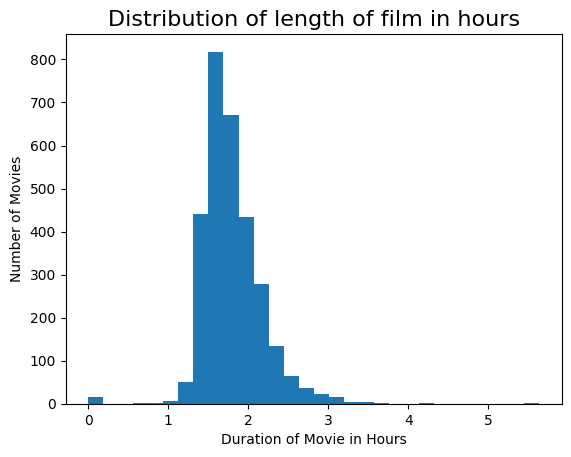

In [24]:
plt.hist(data['runtime'].fillna(0) / 60, bins=30);
plt.title('Distribution of length of film in hours', fontsize=16);
plt.xlabel('Duration of Movie in Hours')
plt.ylabel('Number of Movies')
plt.show()

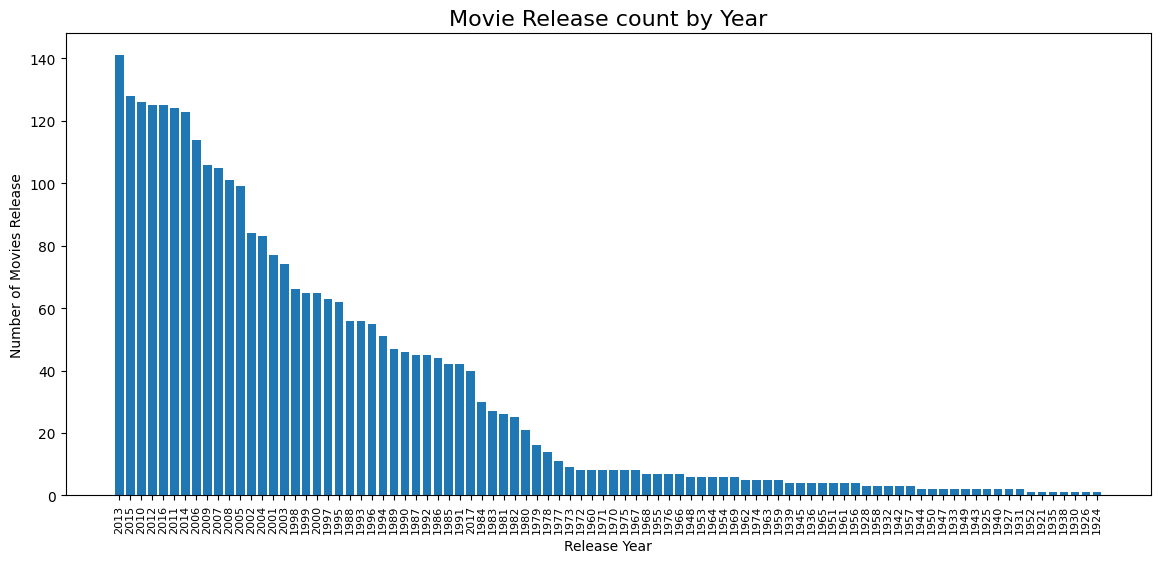

In [25]:
plt.figure(figsize=(14,6))
plt.bar(data['release_year'].value_counts().index,data['release_year'].value_counts().values)
plt.title("Movie Release count by Year", fontsize=16);
plt.xlabel('Release Year')
plt.ylabel('Number of Movies Release')
plt.xticks(fontsize=8,rotation=90)
plt.xticks(data['release_year'].value_counts().index, data['release_year'].value_counts().index)
plt.show()

In [26]:
data['release_month'].value_counts()

9     362
10    307
12    263
8     256
4     245
3     238
6     237
2     226
5     224
11    221
1     212
7     209
Name: release_month, dtype: int64

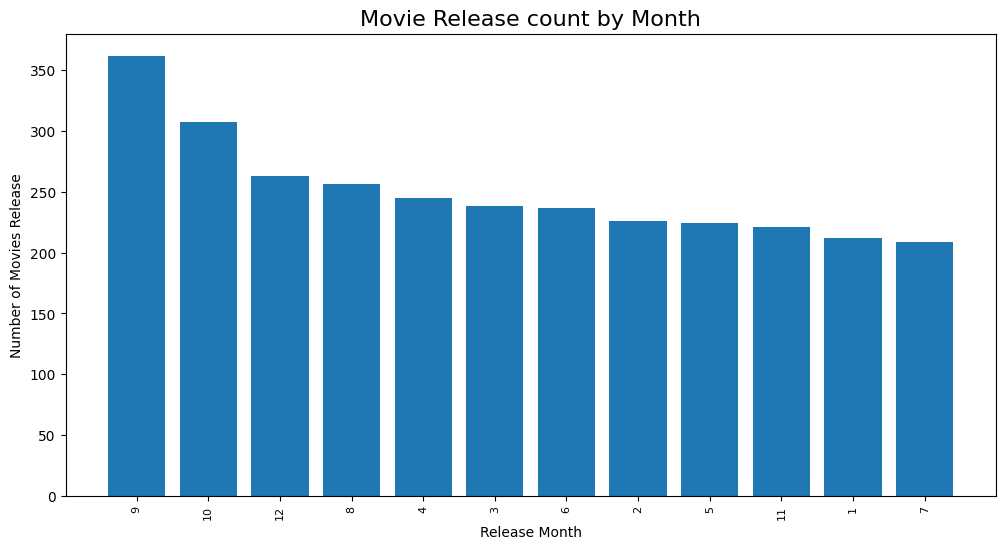

In [27]:
plt.figure(figsize=(12,6))
plt.bar(data['release_month'].value_counts().index,data['release_month'].value_counts().values)
plt.title("Movie Release count by Month", fontsize=16);
plt.xlabel('Release Month')
plt.ylabel('Number of Movies Release')
plt.xticks(fontsize=8,rotation=90)
plt.xticks(data['release_month'].value_counts().index, data['release_month'].value_counts().index)
plt.show()

In [28]:
data['release_day'].value_counts()

1     152
15    126
12    122
7     110
6     107
16    106
25    106
13    106
17    106
9     104
10    104
14    104
22    102
8     101
21     99
18     98
24     97
5      96
2      94
19     94
11     93
4      88
20     87
23     85
26     82
3      80
30     75
28     74
27     74
29     72
31     56
Name: release_day, dtype: int64

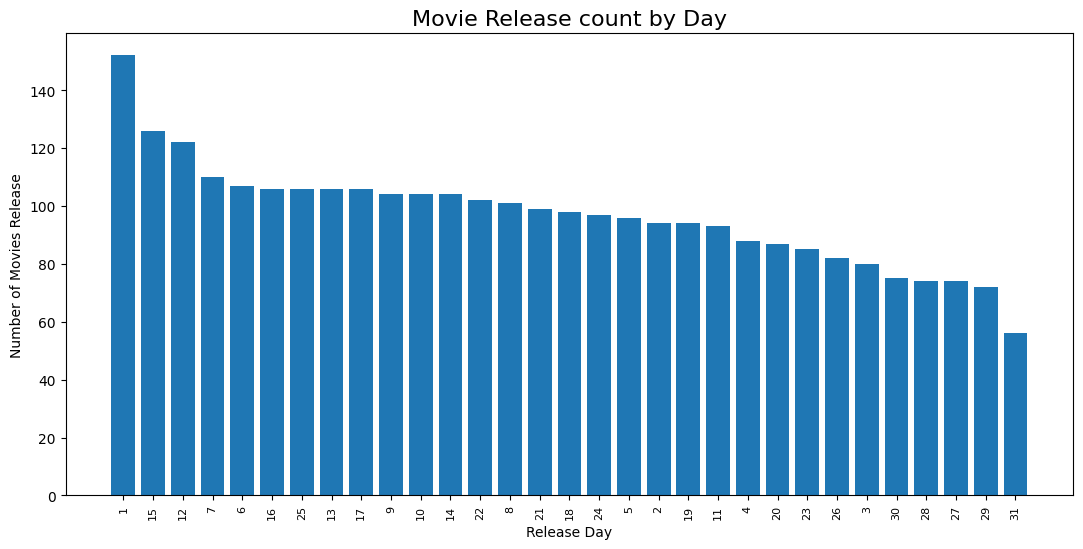

In [29]:
plt.figure(figsize=(13,6))
plt.bar(data['release_day'].value_counts().index,data['release_day'].value_counts().values)
plt.title("Movie Release count by Day", fontsize=16);
plt.xlabel('Release Day')
plt.ylabel('Number of Movies Release')
plt.xticks(fontsize=8,rotation=90)
plt.xticks(data['release_day'].value_counts().index, data['release_day'].value_counts().index)
plt.show()

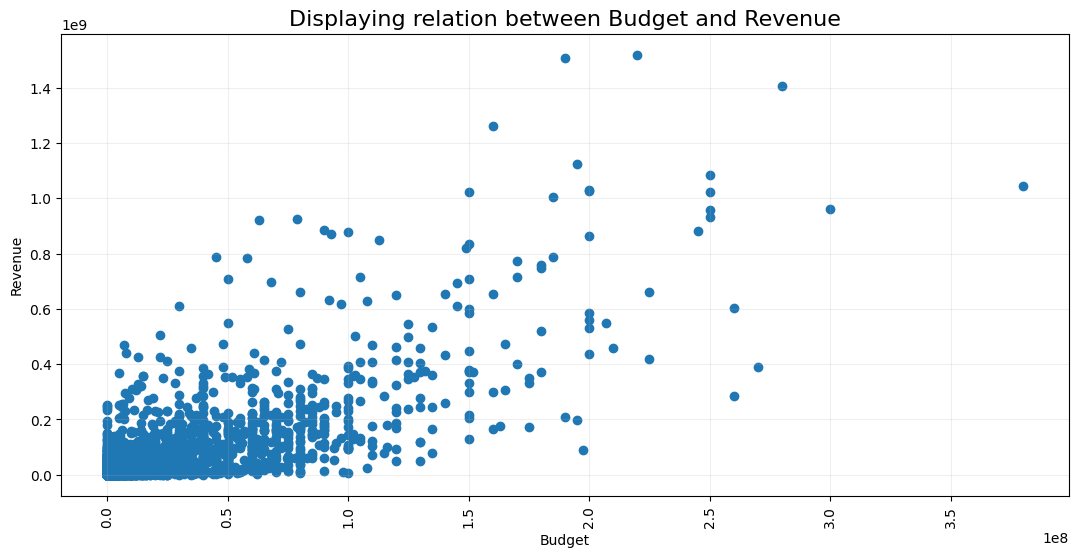

In [30]:
plt.figure(figsize=(13,6))
plt.scatter(data['budget'].values,data['revenue'].values)
plt.grid(alpha = 0.2)
plt.title("Displaying relation between Budget and Revenue", fontsize=16);
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.xticks(fontsize=10,rotation=90)
plt.show()

In [31]:
data.corr()

<ipython-input-31-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,id,budget,popularity,runtime,revenue,num_genres,has_collection,num_companies,num_countries,num_languages,num_cast
id,1.000000,0.019732,-0.007470,0.010750,0.000610,0.009535,-0.010010,0.000435,-0.015624,-0.006256,0.006237
budget,0.019732,1.000000,0.342356,0.238373,0.752965,0.234188,0.222932,0.253386,0.121413,0.101914,0.308950
popularity,-0.007470,0.342356,1.000000,0.133690,0.461460,0.084100,0.155896,0.155638,0.065569,0.036527,0.312118
runtime,0.010750,0.238373,0.133690,1.000000,0.216380,0.057955,-0.036920,0.089640,0.097421,0.182261,0.223421
revenue,0.000610,0.752965,0.461460,0.216380,1.000000,0.163654,0.339425,0.155700,0.052955,0.064961,0.335737
num_genres,0.009535,0.234188,0.084100,0.057955,0.163654,1.000000,0.101065,0.052588,0.032897,0.076848,0.068102
has_collection,-0.010010,0.222932,0.155896,-0.036920,0.339425,0.101065,1.000000,0.007928,0.014250,0.046633,0.098710
num_companies,0.000435,0.253386,0.155638,0.089640,0.155700,0.052588,0.007928,1.000000,0.394400,0.136958,0.162305
num_countries,-0.015624,0.121413,0.065569,0.097421,0.052955,0.032897,0.014250,0.394400,1.000000,0.176328,0.041843
num_languages,-0.006256,0.101914,0.036527,0.182261,0.064961,0.076848,0.046633,0.136958,0.176328,1.000000,0.074356


In [32]:
data_corr = data[['budget','popularity','runtime','revenue']]

<Axes: >

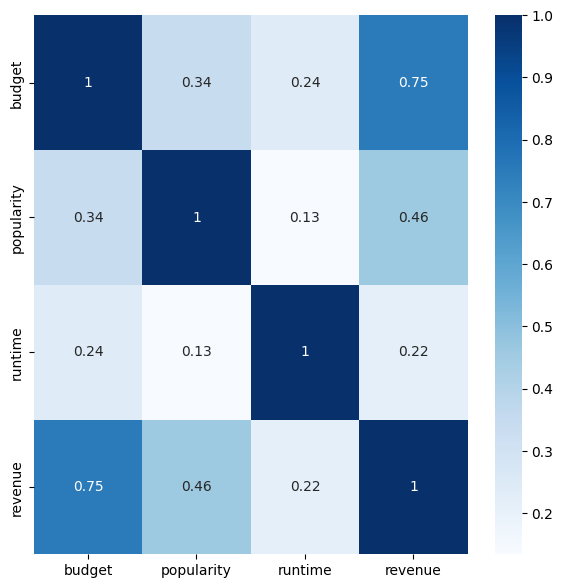

In [33]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(data_corr.corr(), cmap="Blues", annot=True)

In [34]:
list_drop = ['id', 'genres','all_genres', 'belongs_to_collection', 'production_companies', 'all_production_companies',
             'production_countries', 'all_countries', 'spoken_languages', 'all_languages', 'cast', 'crew', 'release_date',
             'homepage', 'imdb_id', 'original_language', 'poster_path', 'status', 'original_title']
data = data.drop(list_drop, axis=1)

In [35]:
data.head()

,budget,overview,popularity,runtime,tagline,title,Keywords,revenue,num_genres,genre_Drama,...,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,release_year,release_day,release_month
0,14000000,"When Lou, who has become the ""father of the In...",6.575393,93.0,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...",12314651,1,0,...,0,0,0,0,0,0,0,2015,20,2
1,40000000,Mia Thermopolis is now a college graduate and ...,8.248895,113.0,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...",95149435,4,1,...,0,0,0,0,0,0,0,2004,6,8
2,3300000,"Under the direction of a ruthless instructor, ...",64.299990,105.0,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...",13092000,1,1,...,0,0,0,0,0,0,0,2014,10,10
3,1200000,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,122.0,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...",16000000,2,1,...,0,0,0,0,0,0,0,2012,9,3
4,0,Marine Boy is the story of a former national s...,1.148070,118.0,NaN,Marine Boy,{},3923970,2,0,...,0,0,0,0,0,0,0,2009,5,2


# Topic Labeling


In [36]:
%%capture
!pip install sentence_transformers --quiet
!pip install umap-learn --quiet
!pip install hdbscan --quiet
!pip install bertopic --quiet

In [37]:
clean_overview = []
for sentence in data['overview']:
    if isinstance(sentence, str):
        clean_overview.append(sentence)

filtered_data = data[data['overview'].isin(clean_overview)]

In [38]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# we add this to remove stopwords
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', calculate_probabilities=True, verbose=True)


In [39]:
topics, probs = model.fit_transform(clean_overview)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2023-07-25 09:53:01,056 - BERTopic - Transformed documents to Embeddings
2023-07-25 09:53:21,948 - BERTopic - Reduced dimensionality
2023-07-25 09:53:22,405 - BERTopic - Clustered reduced embeddings


In [40]:
freq = model.get_topic_info()
freq.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1760,-1_life_new_young_man,"[life, new, young, man, love, story, world, fa...","[Kaitlyn, an ER nurse who is tending to a youn..."
1,0,115,0_love_life_friends_husband,"[love, life, friends, husband, relationship, b...",[Dramatic comedy about two unlikely people who...
2,1,115,1_mother_father_parents_family,"[mother, father, parents, family, son, home, c...","[In 1957, a son and mother flee the East and a..."
3,2,91,2_woman_love_man_comedy,"[woman, love, man, comedy, wife, relationship,...",[Six different writers wrote a scene each of t...
4,3,77,3_princess_prince_evil_kingdom,"[princess, prince, evil, kingdom, king, jesus,...",[The untold story of Disney's most iconic vill...
5,4,74,4_cia_agent_russian_terrorist,"[cia, agent, russian, terrorist, team, preside...",[The mysterious murder of a US senator bearing...
6,5,54,5_zombies_people_students_alice,"[zombies, people, students, alice, lift, undea...","[In a world ravaged by a virus infection, turn..."
7,6,48,6_police_cop_cops_jimmy,"[police, cop, cops, jimmy, officer, kearney, d...","[Big Louis Costillo, last of the old-style gan..."
8,7,45,7_murder_detective_killer_case,"[murder, detective, killer, case, serial kille...",[The story of the battle to free Debbie Peagle...
9,8,44,8_shark_crew_sea_captain,"[shark, crew, sea, captain, ship, island, ocea...",[The luxuriantly bearded Pirate Captain is a b...


In [41]:
fig = model.visualize_topics()
fig.show()

In [42]:
model.visualize_barchart(top_n_topics=12)


In [43]:
model.visualize_hierarchy(top_n_topics=10)


In [44]:
# Get the topic predictions
topic_prediction = model.topics_[:]
# Save the predictions in the dataframe
filtered_data['topic_prediction'] = topic_prediction

In [45]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

max_length = 512  # Maximum sequence length expected by the model

# Tokenize and truncate/pad the input sequences
cut_overview = [overview for overview in filtered_data['overview'].tolist() if len(overview) < max_length]


In [46]:
filtered_data_ = filtered_data[filtered_data['overview'].isin(cut_overview)]

In [47]:
from transformers import pipeline
pred_lst=[]
sentiment_pipeline = pipeline("sentiment-analysis")

for prediction in sentiment_pipeline(filtered_data_['overview'].tolist()):
  if prediction['label'] == "POSITIVE": pred_lst.append(1)
  else :pred_lst.append(0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [48]:
filtered_data_["santiment"] = pred_lst

In [49]:
filtered_data_.head()

,budget,overview,popularity,runtime,tagline,title,Keywords,revenue,num_genres,genre_Drama,...,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,release_year,release_day,release_month,topic_prediction,santiment
0,14000000,"When Lou, who has become the ""father of the In...",6.575393,93.0,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...",12314651,1,0,...,0,0,0,0,0,2015,20,2,-1,0
1,40000000,Mia Thermopolis is now a college graduate and ...,8.248895,113.0,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...",95149435,4,1,...,0,0,0,0,0,2004,6,8,-1,0
2,3300000,"Under the direction of a ruthless instructor, ...",64.299990,105.0,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...",13092000,1,1,...,0,0,0,0,0,2014,10,10,-1,1
4,0,Marine Boy is the story of a former national s...,1.148070,118.0,NaN,Marine Boy,{},3923970,2,0,...,0,0,0,0,0,2009,5,2,-1,1
5,8000000,"Pinocchio and his friends, a glow worm and a m...",0.743274,83.0,NaN,Pinocchio and the Emperor of the Night,{},3261638,3,0,...,0,0,0,0,0,1987,6,8,3,0


In [53]:
# filtered_data_ = filtered_data_.drop(['id', 'belongs_to_collection', 'genres', 'homepage', 'imdb_id','original_title', 'overview',  'poster_path',
#               'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'tagline', 'title', 'Keywords',
#               'cast', 'crew', 'all_genres', 'all_production_companies', 'all_countries', 'all_languages'], axis=1)
# filtered_data_.to_csv('train_with_TL.csv', index=False)

# Modeling

In [78]:
df = pd.read_csv("train_with_TL.csv")

In [55]:
df.head()

,budget,overview,popularity,runtime,tagline,title,Keywords,revenue,num_genres,genre_Drama,...,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,release_year,release_day,release_month,topic_prediction,santiment
0,14000000,"When Lou, who has become the ""father of the In...",6.575393,93.0,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...",12314651,1,0,...,0,0,0,0,0,2015,20,2,-1,0
1,40000000,Mia Thermopolis is now a college graduate and ...,8.248895,113.0,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...",95149435,4,1,...,0,0,0,0,0,2004,6,8,-1,0
2,3300000,"Under the direction of a ruthless instructor, ...",64.299990,105.0,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...",13092000,1,1,...,0,0,0,0,0,2014,10,10,-1,1
3,0,Marine Boy is the story of a former national s...,1.148070,118.0,NaN,Marine Boy,{},3923970,2,0,...,0,0,0,0,0,2009,5,2,-1,1
4,8000000,"Pinocchio and his friends, a glow worm and a m...",0.743274,83.0,NaN,Pinocchio and the Emperor of the Night,{},3261638,3,0,...,0,0,0,0,0,1987,6,8,3,0


In [64]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler ,MinMaxScaler

def prepare_data(df):
    # Separate categorical and numeric columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Prepare categorical columns
    df_categorical = df[categorical_cols].copy()
    for col in categorical_cols:
        df_categorical[col] = df_categorical[col].astype('category').cat.codes

    # Prepare numeric columns
    df_numeric = df[numeric_cols].copy()
    min_max = MinMaxScaler()
    df_numeric[df_numeric.columns] = min_max.fit_transform(df_numeric[df_numeric.columns])

    # Prepare revenue column
    df_revenue = df[['revenue']].copy()
    min_max_revenue = MinMaxScaler()
    min_max_revenue.fit(df_revenue)

    # Combine categorical and numeric columns
    prepared_data = pd.concat([df_categorical, df_numeric], axis=1)

    return min_max_revenue, prepared_data

min_max_revenue, normalized_df = prepare_data(df)

In [65]:
from sklearn.model_selection import train_test_split
y = normalized_df['revenue']
X = normalized_df.drop(['revenue'], axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor


def perform_grid_search(model, X, y, param_grid, cv=5):
    grid_search = GridSearchCV(model, param_grid, cv=cv)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    return best_model, best_params


def evaluate_model(model, train_X, train_y, test_X, test_y):
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)
    train_rmse = mean_squared_error(train_y, train_predictions, squared=False)
    test_rmse = mean_squared_error(test_y, test_predictions, squared=False)
    train_mae = mean_absolute_error(train_y, train_predictions)
    test_mae = mean_absolute_error(test_y, test_predictions)
    train_r2 = r2_score(train_y, train_predictions)
    test_r2 = r2_score(test_y, test_predictions)
    return train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2


def model_cycle(model, train_X, train_y, test_X, test_y, param_grid):
    best_model, best_params = perform_grid_search(model, train_X, train_y, param_grid)
    train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2 = evaluate_model(best_model, train_X, train_y, test_X,
                                                                                   test_y)
    print(model.__class__.__name__)
    print(f'Best Parameters: {best_params}')
    print(f'Train RMSE: {train_rmse:.4f}')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Train MAE: {train_mae:.4f}')
    print(f'Test MAE: {test_mae:.4f}')
    print(f'Train R2 Score: {train_r2:.4f}')
    print(f'Test R2 Score: {test_r2:.4f} \n')

    metric_names = ['RMSE', 'MAE', 'R2 Score']
    train_metrics = [train_rmse, train_mae, train_r2]
    test_metrics = [test_rmse, test_mae, test_r2]

    plt.figure(figsize=(10, 6))
    plt.bar(metric_names, train_metrics, label='Train', alpha=0.5)
    plt.bar(metric_names, test_metrics, label='Test', alpha=0.5)
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Evaluation Metrics - Train vs Test')
    plt.legend()
    plt.show()

    return train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2


LinearRegression
Best Parameters: {'fit_intercept': True}
Train RMSE: 0.0502
Test RMSE: 0.0563
Train MAE: 0.0298
Test MAE: 0.0335
Train R2 Score: 0.6647
Test R2 Score: 0.6983 



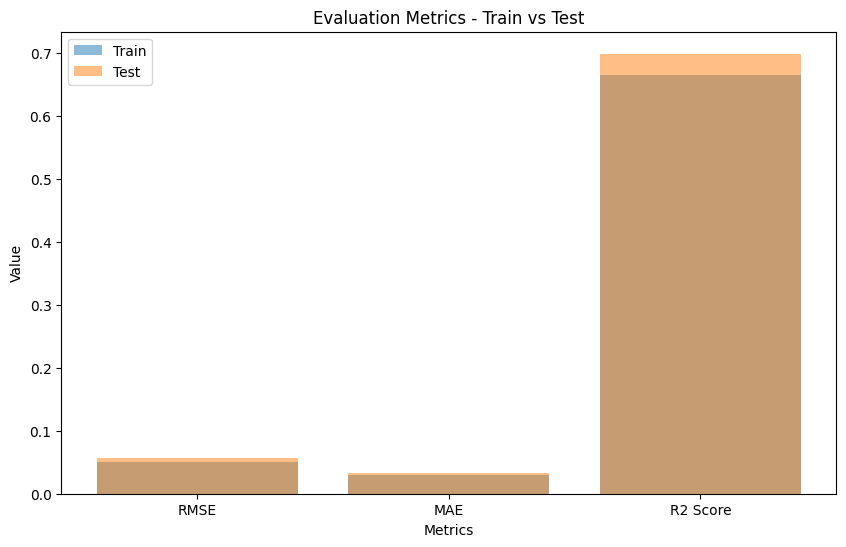

In [67]:
# Model 1: Linear Regression
lr_model = LinearRegression()
lr_param_grid = {'fit_intercept': [True, False]}
lr_metrics = model_cycle(lr_model, train_X, train_y, test_X, test_y, lr_param_grid)

DecisionTreeRegressor
Best Parameters: {'max_depth': 5}
Train RMSE: 0.0397
Test RMSE: 0.0731
Train MAE: 0.0233
Test MAE: 0.0336
Train R2 Score: 0.7901
Test R2 Score: 0.4908 



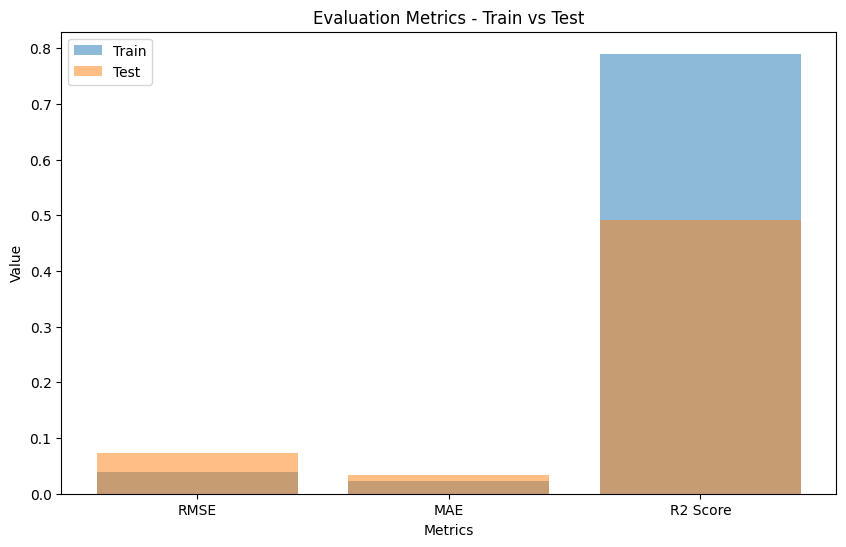

In [68]:
# Model 2: Decision Tree Regressor
dt_model = DecisionTreeRegressor()
dt_param_grid = {'max_depth': [None, 5, 10]}
dt_metrics = model_cycle(dt_model, train_X, train_y, test_X, test_y, dt_param_grid)

MLPRegressor
Best Parameters: {'hidden_layer_sizes': (50, 50)}
Train RMSE: 0.8890
Test RMSE: 1.2418
Train MAE: 0.6775
Test MAE: 0.9195
Train R2 Score: -104.1595
Test R2 Score: -145.9927 



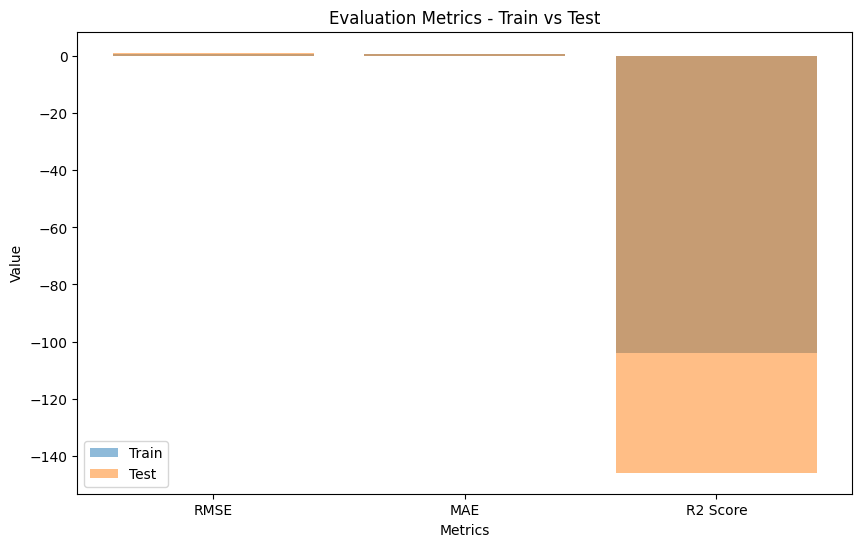

In [69]:
# Model 3: Multi-layer Perceptron (Neural Network)
nn_model = MLPRegressor(random_state=42)
nn_param_grid = {'hidden_layer_sizes': [(50,), (100,), (50, 50)]}
nn_metrics = model_cycle(nn_model, train_X, train_y, test_X, test_y, nn_param_grid)


RandomForestRegressor
Best Parameters: {'n_estimators': 200}
Train RMSE: 0.0185
Test RMSE: 0.0530
Train MAE: 0.0097
Test MAE: 0.0280
Train R2 Score: 0.9543
Test R2 Score: 0.7318 



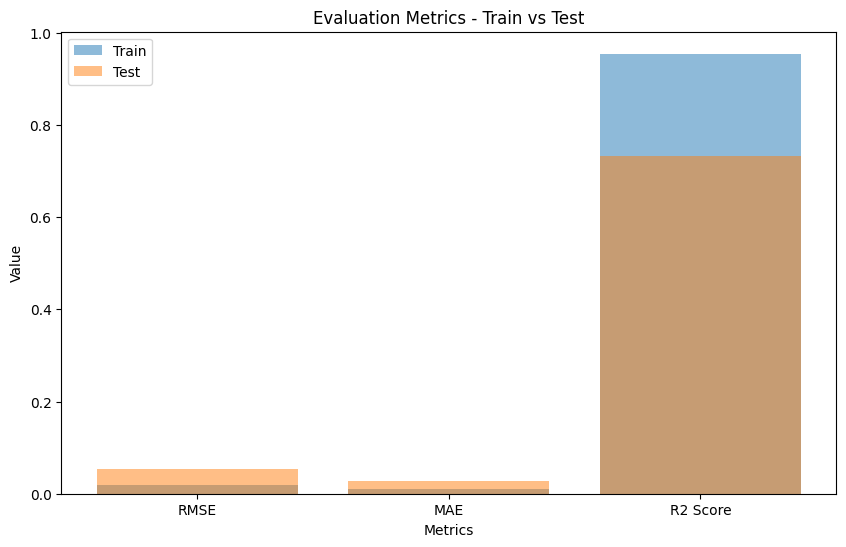

In [70]:
# Model 4: Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {'n_estimators': [50, 100, 200]}
rf_metrics = model_cycle(rf_model, train_X, train_y, test_X, test_y, rf_param_grid)


SVR
Best Parameters: {'C': 10}
Train RMSE: 0.0969
Test RMSE: 0.1092
Train MAE: 0.0798
Test MAE: 0.0818
Train R2 Score: -0.2502
Test R2 Score: -0.1371 



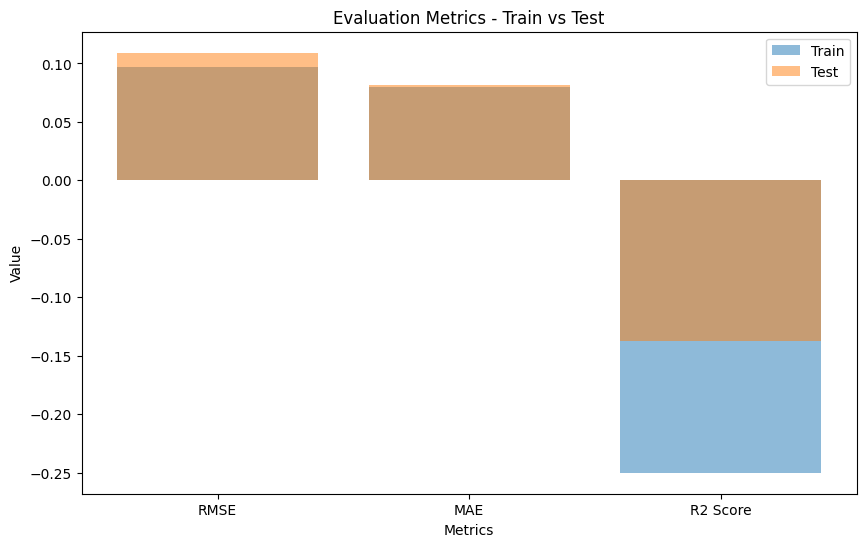

In [71]:
# Model 5: Support Vector Regressor
svr_model = SVR()
svr_param_grid = {'C': [0.1, 1, 10]}
svr_metrics = model_cycle(svr_model, train_X, train_y, test_X, test_y, svr_param_grid)

KNeighborsRegressor
Best Parameters: {'n_neighbors': 7}
Train RMSE: 0.0765
Test RMSE: 0.1045
Train MAE: 0.0413
Test MAE: 0.0534
Train R2 Score: 0.2210
Test R2 Score: -0.0404 



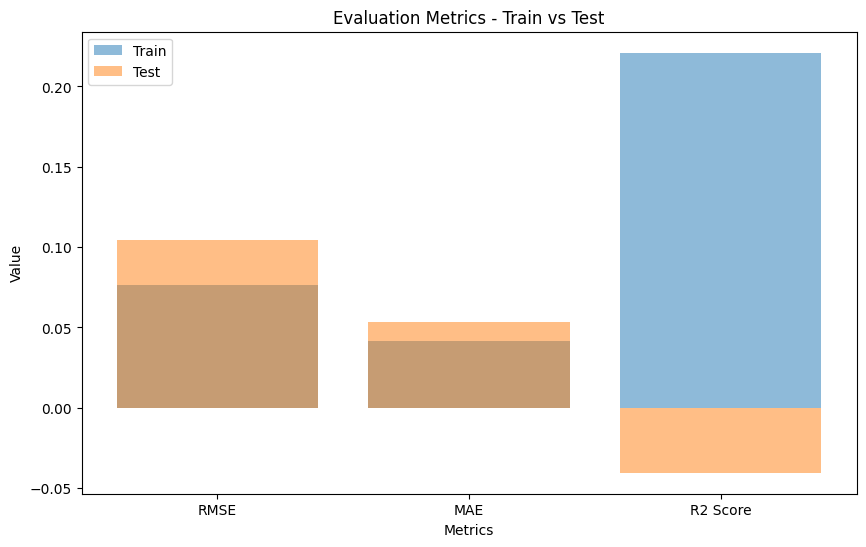

In [72]:
# Model 6: K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()
knn_param_grid = {'n_neighbors': [3, 5, 7]}
knn_metrics = model_cycle(knn_model, train_X, train_y, test_X, test_y, knn_param_grid)

GradientBoostingRegressor
Best Parameters: {'n_estimators': 50}
Train RMSE: 0.0353
Test RMSE: 0.0560
Train MAE: 0.0214
Test MAE: 0.0283
Train R2 Score: 0.8338
Test R2 Score: 0.7010 



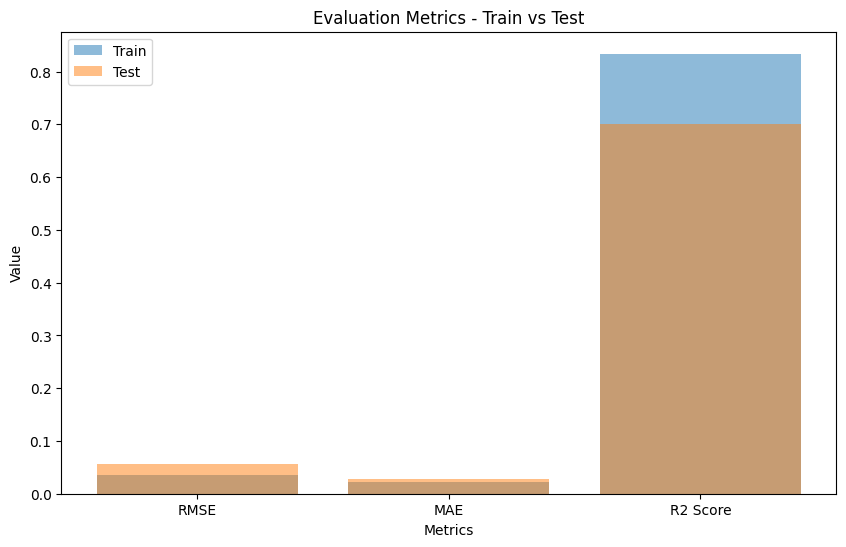

In [73]:
# Model 7: Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_param_grid = {'n_estimators': [50, 100, 200]}
gb_metrics = model_cycle(gb_model, train_X, train_y, test_X, test_y, gb_param_grid)


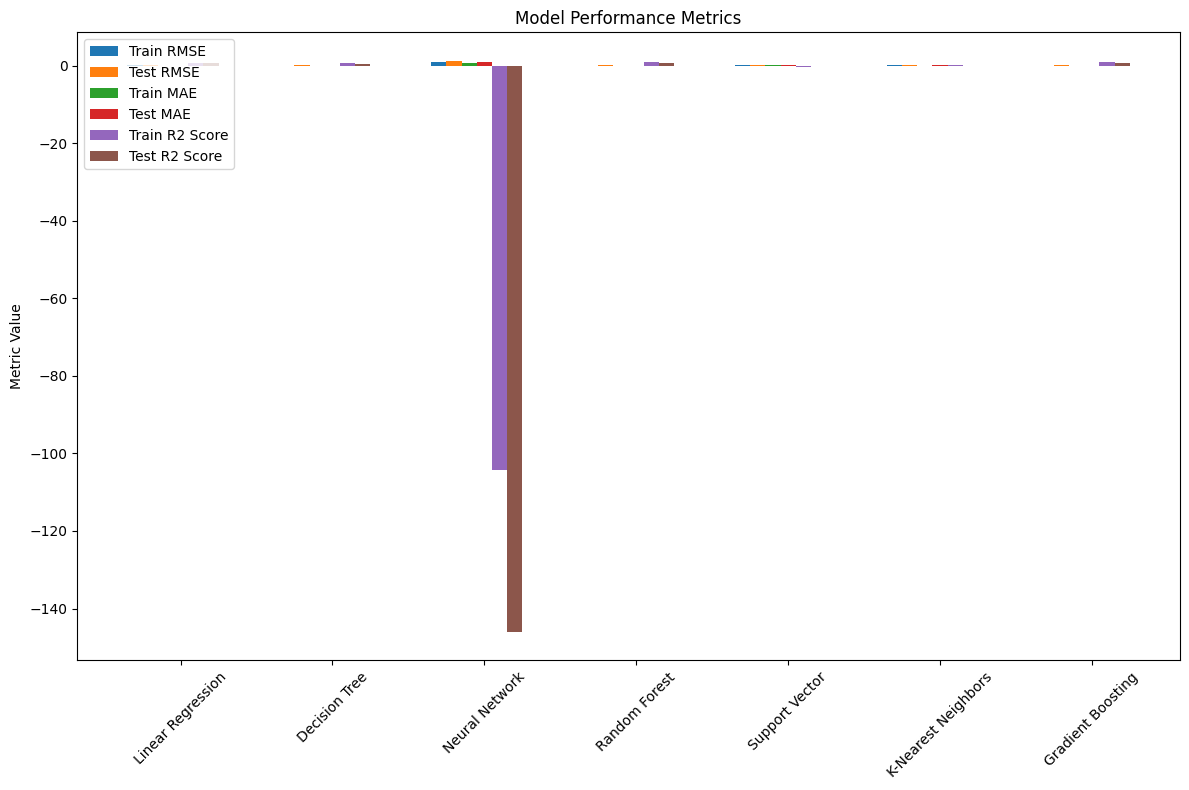

In [74]:
# Bar plot of metrics
models = [
    'Linear Regression',
    'Decision Tree',
    'Neural Network',
    'Random Forest',
    'Support Vector',
    'K-Nearest Neighbors',
    'Gradient Boosting'
]
metrics = ['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE', 'Train R2 Score', 'Test R2 Score']
num_models = len(models)
num_metrics = len(metrics)
width = 0.1

fig, ax = plt.subplots(figsize=(12, 8))
for i in range(num_metrics):
    metric_values = [
        lr_metrics[i],
        dt_metrics[i],
        nn_metrics[i],
        rf_metrics[i],
        svr_metrics[i],
        knn_metrics[i],
        gb_metrics[i]
    ]
    x = np.arange(num_models) + (i * width)
    ax.bar(x, metric_values, width, label=metrics[i])

ax.set_xticks(np.arange(num_models) + (num_metrics * width / 2))
ax.set_xticklabels(models)
ax.set_ylabel('Metric Value')
ax.set_title('Model Performance Metrics')
ax.legend(loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

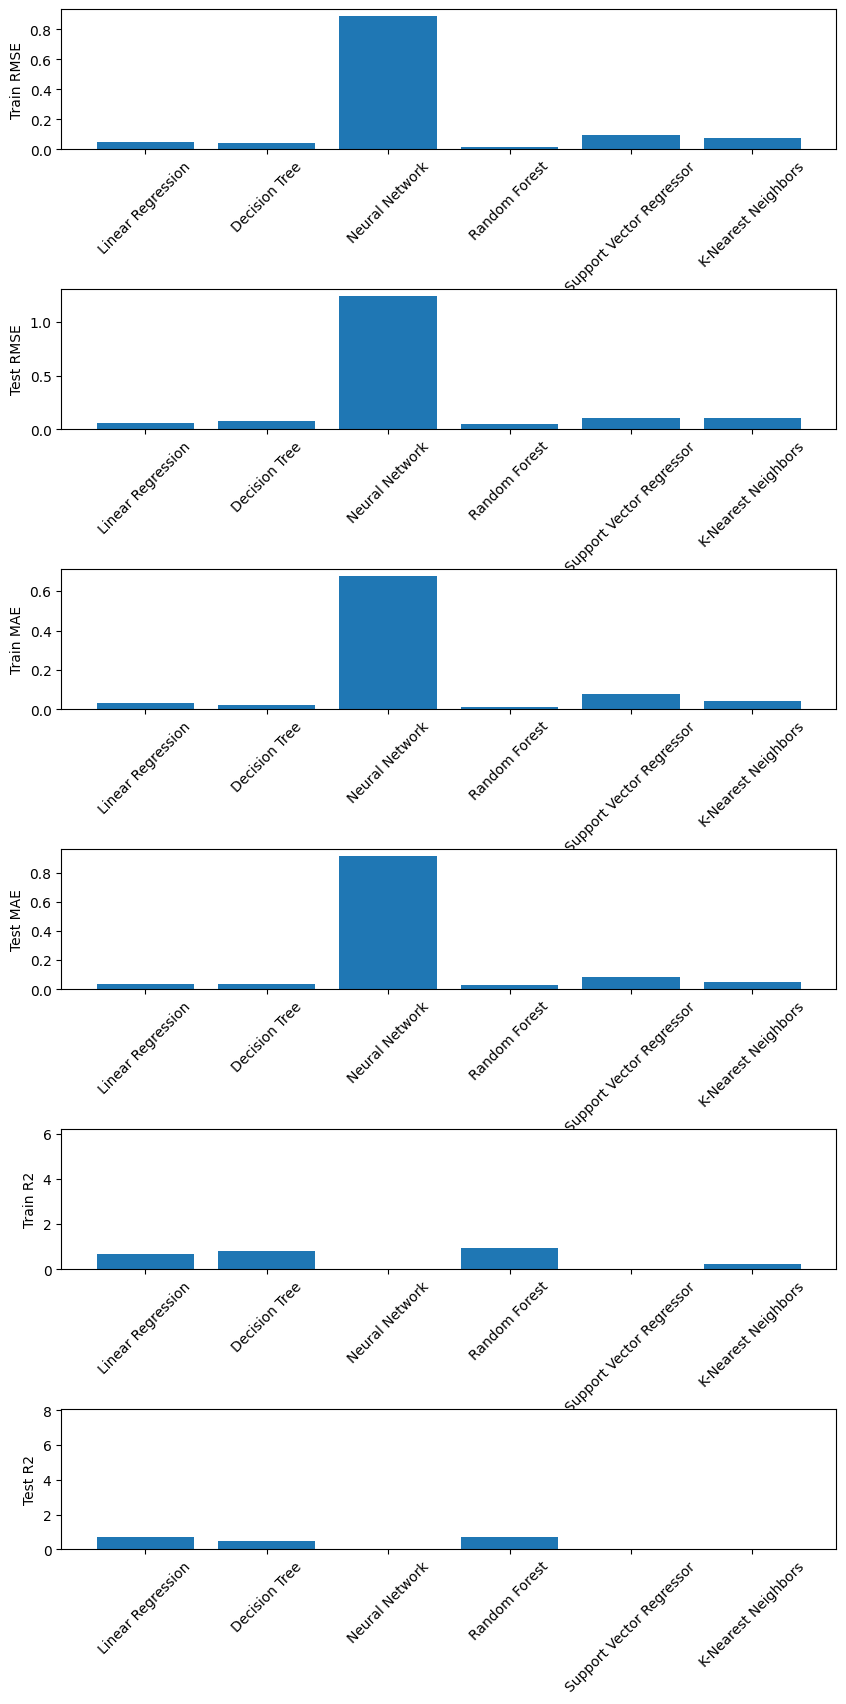

In [75]:
# Create a dictionary to store the metrics of all models
models_metrics = {
    'Linear Regression': lr_metrics,
    'Decision Tree': dt_metrics,
    'Neural Network': nn_metrics,
    'Random Forest': rf_metrics,
    'Support Vector Regressor': svr_metrics,
    'K-Nearest Neighbors': knn_metrics
}

# Plot the performance of each model for each metric
# Plot the performance of each model for each metric
metrics = ['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE', 'Train R2', 'Test R2']
num_models = len(models_metrics)
num_metrics = len(metrics)

fig, axs = plt.subplots(num_metrics, figsize=(10, 20))
fig.subplots_adjust(hspace=1)

for i in range(num_metrics):
    metric_values = [models_metrics[model][i] for model in models_metrics]
    axs[i].bar(models_metrics.keys(), metric_values)
    axs[i].set_ylabel(metrics[i])
    axs[i].set_ylim(bottom=0)
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

plt.show()



# Shap

In [76]:
rf = RandomForestRegressor()
rf.fit(train_X, train_y)

# Get feature importances from the trained model
importances = rf.feature_importances_

# Sort the feature importances in descending order
sorted_indices = importances.argsort()[::-1]

# Get the top K feature names
top_k = 5  # Set the number of top features you want to select
top_k_features = train_X.columns[sorted_indices[:top_k]]

# Print the top K feature names and their importance scores
for feature, importance in zip(top_k_features, importances[sorted_indices[:top_k]]):
    print(feature, round(importance,4))

budget 0.5458
popularity 0.1077
collection_name 0.0514
runtime 0.0373
num_cast 0.0373


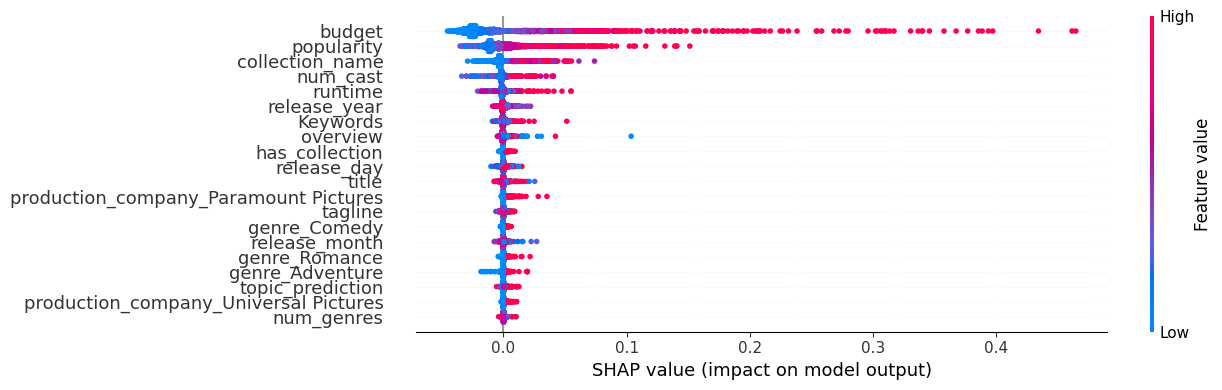

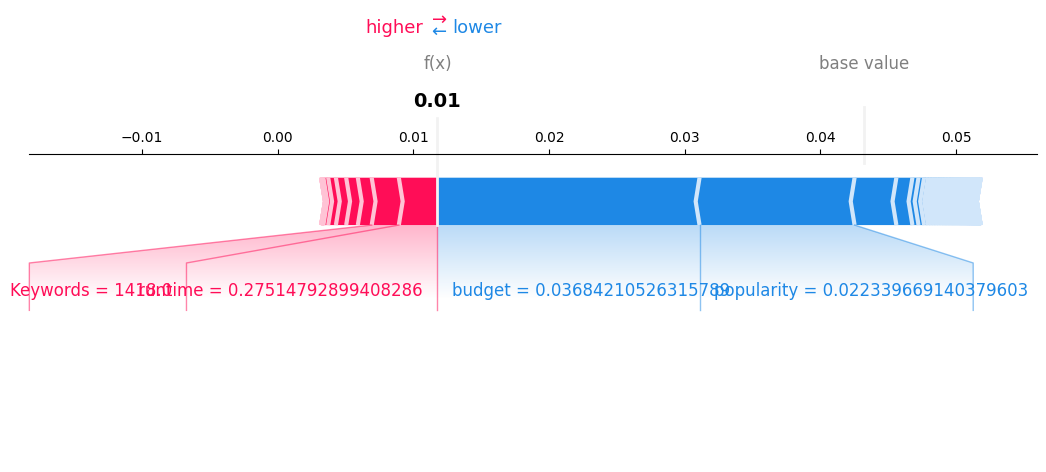

In [77]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(train_X)

# # Visualize SHAP summary plot
shap.summary_plot(shap_values, train_X, plot_size=(13, 4))

# Visualize individual SHAP values for a specific instance
instance_index = 0  # Index of the instance you want to visualize
shap.force_plot(explainer.expected_value, shap_values[instance_index], X.iloc[instance_index], matplotlib=True, figsize=(13, 4))

plt.show()